# Интеллектуальный анализ данных – весна 2025
# Домашнее задание 6: классификация текстов

Правила:



*   Домашнее задание оценивается в 10 баллов.
*   Можно использовать без доказательства любые результаты, встречавшиеся на лекциях или семинарах по курсу, если получение этих результатов не является вопросом задания.
*  Можно использовать любые свободные источники с *обязательным* указанием ссылки на них.
*  Плагиат не допускается. При обнаружении случаев списывания, 0 за работу выставляется всем участникам нарушения, даже если можно установить, кто у кого списал.
*  Старайтесь сделать код как можно более оптимальным. В частности, будет штрафоваться использование циклов в тех случаях, когда операцию можно совершить при помощи инструментов библиотек, о которых рассказывалось в курсе.
* Если в задании есть вопрос на рассуждение, то за отсутствие ответа на него балл за задание будет снижен вполовину.

В этом домашнем задании вам предстоит построить классификатор текстов.

Будем предсказывать эмоциональную окраску твиттов о коронавирусе.



In [1522]:
import numpy as np
import pandas as pd
from typing import  List
import matplotlib.pyplot as plt
import seaborn as sns
from string import punctuation

In [1524]:
df = pd.read_csv('/Users/tima/MyNotebooks/tweets_coronavirus.csv', encoding='latin-1')
df.sample(4)

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
33366,44853,89805,"New York, USA",14-04-2020,Supermarket Madness! https://t.co/2oYivZtfcn\r...,Negative
25520,35057,80009,Sydney,06-04-2020,Exclusive: Panic buying for pets sparks new re...,Negative
21490,30016,74968,"Stoneleigh, Warwickshire",02-04-2020,The EU-spec SPP rose in the week ending 28 Mar...,Positive
1178,5230,50182,"Maryland, USA",17-03-2020,So IÃÂm hearing many myths about #COVID-19 a...,Positive


Для каждого твитта указано:


*   UserName - имя пользователя, заменено на целое число для анонимности
*   ScreenName - отображающееся имя пользователя, заменено на целое число для анонимности
*   Location - местоположение
*   TweetAt - дата создания твитта
*   OriginalTweet - текст твитта
*   Sentiment - эмоциональная окраска твитта (целевая переменная)



## Задание 1 Подготовка (0.5 балла)

Целевая переменная находится в колонке `Sentiment`.  Преобразуйте ее таким образом, чтобы она стала бинарной: 1 - если у твитта положительная или очень положительная эмоциональная окраска и 0 - если отрицательная или очень отрицательная.

In [1529]:
df['Sentiment'] = df['Sentiment'].replace({'Positive': 1, 'Extremely Positive': 1, 'Negative': 0, 'Extremely Negative': 0}).astype(int)
df.shape

/var/folders/j4/79fj4fn91zlb8wkydvy_zbf00000gn/T/ipykernel_88845/717082825.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['Sentiment'] = df['Sentiment'].replace({'Positive': 1, 'Extremely Positive': 1, 'Negative': 0, 'Extremely Negative': 0}).astype(int)


(33444, 6)

Сбалансированы ли классы?

In [1532]:
df['Sentiment'].value_counts()

Sentiment
1    18046
0    15398
Name: count, dtype: int64

**Ответ:** Да, сбалансированны, так как позитивных твиттов всего на 17% больше.

Выведете на экран информацию о пропусках в данных. Если пропуски присутствуют заполните их строкой 'Unknown'.

In [1536]:
print(f"Количество пропусков в исследуемом датасете по признакам:\n{pd.DataFrame(df.isna().sum(), columns=['Sum'])}")
print(f"\nЗаменяем пропущенные значения на 'Unknown'\n")
df.fillna('Unknown', inplace=True)
print(f"Количество пропусков в исследуемом датасете по признакам:\n{pd.DataFrame(df.isna().sum(), columns=['Sum'])}")

Количество пропусков в исследуемом датасете по признакам:
                Sum
UserName          0
ScreenName        0
Location       7049
TweetAt           0
OriginalTweet     0
Sentiment         0

Заменяем пропущенные значения на 'Unknown'

Количество пропусков в исследуемом датасете по признакам:
               Sum
UserName         0
ScreenName       0
Location         0
TweetAt          0
OriginalTweet    0
Sentiment        0


Разделите данные на обучающие и тестовые в соотношении 7 : 3 и укажите `random_state=0`

In [1539]:
from sklearn.model_selection import train_test_split


train, test = train_test_split(df, test_size=0.3, random_state=0)

## Задание 2 Токенизация (3 балла)

Постройте словарь на основе обучающей выборки и посчитайте количество встреч каждого токена с использованием самой простой токенизации - деления текстов по пробельным символам и приведения токенов в нижний регистр.

In [1543]:
tokens = {}

for tweet in train['OriginalTweet']:
    tweet_splitted = tweet.lower().split()
    for word in tweet_splitted:
        if word not in tokens:
            tokens[word] = 1
        else:
            tokens[word] += 1

Какой размер словаря получился?

In [1546]:
len(tokens)

79755

Выведите 10 самых популярных токенов с количеством встреч каждого из них. Объясните, почему именно эти токены в топе.

In [1549]:
tokens_sorted_desc = sorted(tokens.items(), key=lambda x: x[1], reverse=True)
tokens_pplr_top10 = pd.DataFrame(tokens_sorted_desc[:10], columns=['Token', 'Count'])

print(f"Топ-10 самых популярных слов:")
tokens_pplr_top10

Топ-10 самых популярных слов:


,Token,Count
0,the,26815
1,to,23373
2,and,14684
3,of,13012
4,a,11737
5,in,11198
6,for,8566
7,#coronavirus,8223
8,is,7383
9,are,7050


**Ответ:** Популярность артиклей: <i>the, a</i>; предлогов: <i>to, of, in, for</i>; а также форм глагола to be: <i>is, are</i> объяснима тем, что предлоги используются перед подавляющим количеством существительных; предлоги связывают одни существительные с другими; а формы глагола to be сами по себе означают <i>быть, являться, есть</i>, то есть являются глаголами состояния или явления.
В силу того, что датасет является датасетом твиттов в течение коронавируса, и в то время глобальная пандемия воцарилась по всей планете, поэтому очевидно, почему люди так часто говорили или писали о ней.

Удалите стоп-слова из словаря и выведите новый топ-10 токенов (и количество встреч) по популярности.  Что можно сказать  о нем?

In [1553]:
import nltk
from nltk.corpus import stopwords

nltk.download("stopwords", quiet=True)
stopwords_list = stopwords.words("english")

print("Топ-10 самых популярных слов за исключение стоп-слов:")
i = 1
for token in tokens_sorted_desc:
    word, cnt = token
    if word not in stopwords_list:
        print(f"{i}) {word}: {cnt}")
        i += 1

    if i == 11:
        break

Топ-10 самых популярных слов за исключение стоп-слов:
1) #coronavirus: 8223
2) prices: 3891
3) food: 3820
4) grocery: 3469
5) supermarket: 3288
6) people: 3175
7) covid-19: 3173
8) store: 3155
9) #covid19: 2471
10) &amp;: 2314


**Ответ:**  С <i>#coronavirus, covid-19 и #covid19</i> все уже предельно очевидно. На начальных этапах коронавируса люди активно скупали <i>продукты первой необходимости в магазинах</i>, ожидая чего-то неладного и порой оставляя пустые полки. На фоне ковида также произошел глобальный кризис, который считается, худшим с времен Великой депрессии: резко упали <i>цены</i> на бензин, росли <i>цены</i> на <i>продукты питания</i>. Также именно этот год стал точкой роста для <i>доставок еды и продуктов питания</i> домой. Это и послужило популярности слова <i>consumer</i> в связи изменениям товарного рынка и реакцией потребителя на это. Не стоит забывать про американские протесты после убийства Джорджа Флойда и сопровождающие их мародерство и беспорядки: куча народа толпами вламывались в <i>магазины</i> и крали все что угодно. Слово <i>people</i? в целом довольно популярное слово, но также могу предположить, что его часто использовали в контексте подсчета заболевших/умерших от коронавируса. 


Также выведите 20 самых непопулярных слов (если самых непопулярных слов больше, выведите любые 20 из них) Почему эти токены непопулярны, требуется ли как-то дополнительно работать с ними?

In [1557]:
from random import choice

tokens_sorted_asc = sorted(tokens.items(), key=lambda x: x[1])

cnt = 0 # Количество токенов с количеством использования, равного 1.
while tokens_sorted_asc[cnt][1] == 1:
    cnt += 1

tokens_one_usage = tokens_sorted_asc[:cnt]
tokens_unpplr_top20 = [choice(tokens_one_usage) for _ in range(20)]

print("Топ-20 самых непопулярных слов")
i = 1
for token in tokens_unpplr_top20:
    word, cnt = token
    print(f"{i}) {word}: {cnt}")
    i += 1

Топ-20 самых непопулярных слов
1) https://t.co/62kg2laxsa: 1
2) #seminoleheightsunite: 1
3) https://t.co/v0cbidnywk: 1
4) house,i: 1
5) https://t.co/ayf4ckkul8: 1
6) oliverãâs: 1
7) livable: 1
8) https://t.co/uclswwdqna: 1
9) https://t.co/hypqci20ye: 1
10) #goptaxscam: 1
11) 22,115: 1
12) #seasoning: 1
13) https://t.co/brxcm3agua: 1
14) https://t.co/i52bhgr012: 1
15) time.ãâ: 1
16) @orlandomayor: 1
17) https://t.co/abewlpih34: 1
18) ?canalys: 1
19) #studiocity: 1
20) https://t.co/apr3lm4hct: 1


**Ответ:** 
* Местечковые ссылки, которые могут ссылаться на непопулярные видео, статьи, посты в других социальных сетях. 
* Отметки других людей, например, своих близких, друзей или коллег по работе.
* Хештеги, описывающие непопулярные места (маленькие города, речки, регионы) и события, и хештеги-фразы.
* Фразы на непопулярных языках.
* Слова, скрепленные знаком(-ами) препинания или слово с знаком препинания после.

Определенно нужна работа, например, со словами, скрепленными с знаками препинания. По сути их нужно отделять, так как вкупе они не несут никакого смысла и снижают статистику использования слова.


Теперь воспользуемся токенайзером получше — TweetTokenizer из библиотеки nltk. Примените его и посмотрите на топ-10 популярных слов. Чем он отличается от топа, который получался раньше? Почему?

In [1561]:
from nltk.tokenize import TweetTokenizer

tw = TweetTokenizer()
tweets_tokenized = [tw.tokenize(tweet.lower()) for tweet in train['OriginalTweet']]
tokens_tweet_tokenizer = {}

for tweet_tokenized in tweets_tokenized:
    for word in tweet_tokenized:
        if word not in tokens_tweet_tokenizer:
            tokens_tweet_tokenizer[word] = 1
        else:
            tokens_tweet_tokenizer[word] += 1

tokens_tweet_tokenizer_sorted_desc = sorted(tokens_tweet_tokenizer.items(), key=lambda x: x[1], reverse=True)
tokens_tweet_tokenizer_pplr_top10 = tokens_tweet_tokenizer_sorted_desc[:10]

print("Топ-10 самых популярных слов по версии TweetTokenizer:") # в дальнейшем я не буду упоминать TweetTokenizer.
i = 1
for token in tokens_tweet_tokenizer_pplr_top10:
    word, cnt = token
    print(f"{i}) {word}: {cnt}")
    i += 1

Топ-10 самых популярных слов по версии TweetTokenizer:
1) the: 26993
2) .: 24118
3) to: 23478
4) ,: 17571
5) and: 14825
6) of: 13044
7) a: 11891
8) in: 11348
9) ?: 9524
10) #coronavirus: 8808


**Ответ:** Отличается тем, что TweetTokenizer открепил знаки препинания от слов, и теперь наиболее популярные знаки препинания, а именно <i>точка, запятая и вопросительный знак</i> вошли в топ-10 токенов, вытеснив коронавирус, предлоги и формы глагола to be.

Удалите из словаря стоп-слова и пунктуацию, посмотрите на новый топ-10 слов с количеством встреч, есть ли теперь в нем что-то не похожее на слова?

In [1564]:
from string import punctuation

noise = stopwords.words("english") + list(punctuation)

for token in noise:
    if token in tokens_tweet_tokenizer:
        del tokens_tweet_tokenizer[token]

tokens_tweet_tokenizer_sorted_desc = sorted(tokens_tweet_tokenizer.items(), key=lambda x: x[1], reverse=True)
tokens_tweet_tokenizer_pplr_top10 = pd.DataFrame(tokens_tweet_tokenizer_sorted_desc[:10], columns=['Token', 'Count'])

print(tokens_tweet_tokenizer_pplr_top10)

print(f"\n '{tokens_tweet_tokenizer_pplr_top10[7:8]}'")

          Token  Count
0  #coronavirus   8808
1             â   7415
2                7311
3            19   7167
4         covid   6253
5        prices   4601
6                4372
7          food   4367
8         store   3877
9   supermarket   3805

 '  Token  Count
7  food   4367'


**Ответ:** Пропали артикли и предлоги. Вернулись те же слова, что и при обычном токенизаторе: #coronavirus, prices, COVID, food, store. <i>19</i> — потому что люди часто писали <i>covid 19</i> раздельно. <i>I</i> — люди части пишут в твиттах о себе, что сегодня забавное/радостное/плохое с ними случилось, что они сделали или, когда говорят о своих чувствах. По поводу <i>\x92</i>, я не мог понять, что это и оно не гуглилось, поэтому я обратился в гпт, и он сказал, что это некорректно отображенный апостроф. Это точно имеет смысл, потому что в английском языке апостроф используется для сокращения форм глагола to be и do при отрицании. Аналогичная ситуация с <i>Â</i>.

Скорее всего в некоторых топах были неотображаемые символы или отдельные буквы не латинского алфавита. Уберем их: удалите из словаря токены из одного символа, позиция которого в таблице Unicode 128 и более (`ord(x) >= 128`)

Выведите топ-10 самых популярных и топ-20 непопулярных слов. Чем полученные топы отличаются от итоговых топов, полученных при использовании токенизации по пробелам? Что теперь лучше, а что хуже?

In [1569]:
filtered_tokens_tweet_tokenizer = tokens_tweet_tokenizer.copy()
for token in tokens_tweet_tokenizer:
    if len(token) == 1:
        if ord(token) >= 128:
            del filtered_tokens_tweet_tokenizer[token]

filtered_tokens_tweet_tokenizer_desc = sorted(filtered_tokens_tweet_tokenizer.items(), key=lambda x: x[1], reverse=True)
filtered_tokens_tweet_tokenizer_pplr_top10 = pd.DataFrame(filtered_tokens_tweet_tokenizer_desc[:10], columns=['Token', 'Count'])

print("Топ-10 самых популярных слов за исключением стоп-слов, пунктуации и токенов из одного символа со значением в таблице Unicode 128 или более:")
print(filtered_tokens_tweet_tokenizer_pplr_top10)
filtered_tokens_tweet_tokenizer_asc = sorted(filtered_tokens_tweet_tokenizer.items(), key=lambda x: x[1])

cnt = 0 # Количество токенов с количеством использования, равного 1.
while filtered_tokens_tweet_tokenizer_asc[cnt][1] == 1:
    filtered_tokens_tweet_tokenizer_asc[cnt][1]
    cnt += 1

filtered_tokens_one_usage = filtered_tokens_tweet_tokenizer_asc[:cnt]
filtered_tokens_unpplr_top20 = pd.DataFrame([choice(filtered_tokens_one_usage) for _ in range(20)], columns=['Token', 'Count'])

print("\nТоп-20 самых непопулярных слов за исключением стоп-слов, пунктуации и токенов из одного символа со значением в таблице Unicode 128 или более:")
i = 1
print(filtered_tokens_unpplr_top20)

Топ-10 самых популярных слов за исключением стоп-слов, пунктуации и токенов из одного символа со значением в таблице Unicode 128 или более:
          Token  Count
0  #coronavirus   8808
1            19   7167
2         covid   6253
3        prices   4601
4          food   4367
5         store   3877
6   supermarket   3805
7       grocery   3523
8        people   3463
9      #covid19   2589

Топ-20 самых непопулярных слов за исключением стоп-слов, пунктуации и токенов из одного символа со значением в таблице Unicode 128 или более:
                      Token  Count
0                  #loyalty      1
1   https://t.co/gaqzx4q0kz      1
2                 wildfires      1
3                     fries      1
4                      4all      1
5           #fastestgrowing      1
6                  unfunded      1
7   https://t.co/psykgnogyp      1
8   https://t.co/utzkg90nzi      1
9                   binding      1
10              @politikurd      1
11  https://t.co/om9hgukwfu      1
12       

**Ответ:**
* Отличается тем, что в полученном топе взлетело по популярности слово <i>I</i> за счет того, что его зачастую используют вместе с сокращенным артиклем <i>I'm</i>, а TweetTokenizer воспринимает пунктуацию, как отдельный токен. Также видно, как увеличились счетчики количества токенов обычных слов, потому что они были откреплены от пунктуации. НО, так как TweetTokenizer воспринимает дефис как пунктуацию, то в топы залетело число <i>19</i>, потому что его использовали в контексте <i>covid-19</i>.
* Относительно наименее встречающихся токенов особо ничего не изменилось. Остались те же ссылки, отметки, редкие хештеги. Пропали лишь слова со странной пунктуацией с многоточием и другими знаками.

Выведите топ-10 популярных хештегов (токены, первые символы которых - #) с количеством встреч. Что можно сказать о них?

In [1573]:
top10_hashtags = pd.DataFrame(filtered_tokens_tweet_tokenizer_desc[:10], columns=['Token', 'Count'])
top10_hashtags

,Token,Count
0,#coronavirus,8808
1,19,7167
2,covid,6253
3,prices,4601
4,food,4367
5,store,3877
6,supermarket,3805
7,grocery,3523
8,people,3463
9,#covid19,2589


**Ответ:** 8/10 хештегов связаны с названием вируса в том или ином написании. Причем оставшийся тоже связан с ковидом. Все из-за аномального высокого спроса на туалетную бумагу в разгар эпидемии.

То же самое проделайте для ссылок на сайт https://t.co Сравнима ли популярность ссылок с популярностью хештегов? Будет ли информация о ссылке на конкретную страницу полезна?

In [1577]:
i = 1
for token in filtered_tokens_tweet_tokenizer_desc:
    word, cnt = token
    if word[:12] == 'https://t.co':
        print(f"{i}) {word}: {cnt}")
        i += 1

    if i == 11:
        break

1) https://t.co/oxa7swtond: 5
2) https://t.co/gp3eusapl8: 4
3) https://t.co/deftrui1pfãâ: 3
4) https://t.co/wrlhyzizaa: 3
5) https://t.co/kuwipf1kqw: 3
6) https://t.co/zjnrx6dkkn: 3
7) https://t.co/3gbbdpdjat: 3
8) https://t.co/e2znxajpre: 3
9) https://t.co/catkegayoy: 3
10) https://t.co/g63rp042ho: 3


**Ответ:** Хештеги в сотни раз популярнее. Сайты, которые у меня получилось открыть, также напрямую или косвенно связаны с ковидом. Учитывая такую низкую популярность (что аж самая популярная ссылка была упомянута лишь в 5 твиттах), рассматривать ссылки бесполезно.

Используем опыт предыдущих экспериментов и напишем собственный токенайзер, улучшив TweetTokenizer. Функция tokenize должна:



*   Привести текст в нижний регистр
*   Применить TweetTokenizer для  выделения токенов
*   Удалить стоп-слова, пунктуацию, токены из одного символа с позицией в таблице Unicode 128 и более,  ссылки на t.co



In [1591]:
def custom_tokenizer(text):
    text = text.lower()
    tokens = tw.tokenize(text)
    noise = stopwords.words("english") + list(punctuation)
    
    tokens = [token for token in tokens if token not in noise and not token.startswith("https://t.co/")]
    tokens = [token for token in tokens if not (len(token) == 1 and ord(token) >= 128)]
    
    return tokens


In [1593]:
custom_tokenizer('This is sample text!!!! @Sample_text I, \x92\x92 https://t.co/sample  #sampletext')

['sample', 'text', '@sample_text', '#sampletext']

## Задание 3 Векторизация текстов (2 балла)

Обучите CountVectorizer с использованием custom_tokenizer в качестве токенайзера. Как размер полученного словаря соотносится с размером изначального словаря из начала задания 2?

In [1599]:
from sklearn.feature_extraction.text import CountVectorizer

cv = CountVectorizer(tokenizer=custom_tokenizer, token_pattern=None)
X_cv = cv.fit_transform(train["OriginalTweet"])

print(f"Количество токенов при простой токенизации: {len(tokens)}")
print(f"Количество токенов при CountVectorizer: {len(cv.vocabulary_)}")
print(f"Количество токенов при использовании CountVectorizer в {round(len(cv.vocabulary_) / len(tokens), 2)} раза меньше, чем при простой токенизации")

Количество токенов при простой токенизации: 79755
Количество токенов при CountVectorizer: 45290
Количество токенов при использовании CountVectorizer в 0.57 раза меньше, чем при простой токенизации


**Ответ:** Словарь меньше в 0.57 раз.

Посмотрим на какой-нибудь конкретный твитт:

In [1603]:
ind = 9023
train.iloc[ind]['OriginalTweet'], train.iloc[ind]['Sentiment']

('Nice one @SkyNews lets not panic but show ppl in france queueing for food!!! #CoronavirusOutbreak #COVID2019 brainless!! Ffs',
 0)

Автор твитта не доволен ситуацией с едой во Франции и текст имеет резко негативную окраску.

Примените обученный CountVectorizer для векторизации данного текста, и попытайтесь определить самый важный токен и самый неважный токен (токен, компонента которого в векторе максимальна/минимальна, без учета 0). Хорошо ли они определились, почему?

In [1606]:
tweet = train.iloc[ind]['OriginalTweet']
feature_names = cv.get_feature_names_out()
X_new = cv.transform([tweet])

vector = X_new.toarray()[0]
non_zero = {
    word: count 
    for word, count in zip(feature_names, vector) 
    if count > 0
}

most_important = max(non_zero.items(), key=lambda x: x[1])
least_important = min(non_zero.items(), key=lambda x: x[1])

print(pd.DataFrame(list(non_zero.items()), columns=['Token', 'Count']), '\n')
print(f"Самый важный токен: {most_important[0]}\nСамый неважный токен: {least_important[0]}")

                   Token  Count
0   #coronavirusoutbreak      1
1             #covid2019      1
2               @skynews      1
3              brainless      1
4                    ffs      1
5                   food      1
6                 france      1
7                   lets      1
8                   nice      1
9                    one      1
10                 panic      1
11                   ppl      1
12              queueing      1
13                  show      1 

Самый важный токен: #coronavirusoutbreak
Самый неважный токен: #coronavirusoutbreak


**Ответ:** Самым важным и неважным токеном является <i>#coronavirusoutbreak</i>, так как все слова встречаются по одному разу, соответственно, случайное слово выбирается.

Теперь примените TfidfVectorizer и  определите самый важный/неважный токены. Хорошо ли определились, почему?

In [1611]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vec = TfidfVectorizer()
X_tfidf = tfidf_vec.fit_transform(train["OriginalTweet"])
feature_names = tfidf_vec.get_feature_names_out()

X_new = tfidf_vec.transform([tweet])

vector = X_new.toarray()[0]
non_zero = {
    word: count 
    for word, count in zip(feature_names, vector) 
    if count > 0
}

most_important = max(non_zero.items(), key=lambda x: x[1])
least_important = min(non_zero.items(), key=lambda x: x[1])

print(f"Самый важный токен: {most_important[0]}\nСамый неважный токен: {least_important[0]}")

Самый важный токен: brainless
Самый неважный токен: in


**Ответ:** Самым важным токеном является <i>brainless</i> переводится как <i>безмозглый, глупый</i>. TfidfVectorizer довольно хорошо определил его важность, так как это слово обычно используется в негативном контексте, а именно при оценке вещей, людей и их действий или решений. TF-IDF также хорошо справился с самым неважным токеном: <i>in</i> — предлог, и он никак не влияет на окраску предложения. 

Найдите какой-нибудь положительно окрашенный твитт, где TfidfVectorizer хорошо (полезно для определения окраски) выделяет важный токен, поясните пример.

*Подсказка:* явно положительные твитты можно искать при помощи положительных слов (good, great, amazing и т. д.)

In [1615]:
tweet = train[train['OriginalTweet'].apply(lambda x: 'amazing' in x) & (train['Sentiment'] == 1)].iloc[5]['OriginalTweet']
print(tweet)

With everything going on with 19 shopping online is the best way to stay safe while still getting what you need Check out this amazing article on how to choose your foundation online  


In [1617]:
X_new = tfidf_vec.transform([tweet])

vector = X_new.toarray()[0]
non_zero = {
    word: count 
    for word, count in zip(feature_names, vector) 
    if count > 0
}

most_important = max(non_zero.items(), key=lambda x: x[1])
least_important = min(non_zero.items(), key=lambda x: x[1])

print(f"Самый важный токен: {most_important[0]}\nСамый неважный токен: {least_important[0]}")

Самый важный токен: foundation
Самый неважный токен: the


**Ответ:** TfidfVectorizer хорошо выделил самый важен токен <i>foundation</i>, который в данном случае означает тональный крем. <i>Foundation</i> является омонимом, но все равно упоминание тонального крема и других значений слова мало в твиттах. С неважным токеном все также предельно очевидно - это артикль.

## Задание 4 Обучение первых моделей (1 балл)

Примените оба векторайзера для получения матриц с признаками текстов.  Выделите целевую переменную.

In [1622]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

X_train, X_test, y_train, y_test = train_test_split(df.OriginalTweet, df.Sentiment, stratify=df.Sentiment, random_state=0, test_size=0.3)

vec_cv = CountVectorizer()
bow_cv= vec_cv.fit_transform(X_train) 
bow_test_cv = vec_cv.transform(X_test)

vec_tfidf = TfidfVectorizer()
bow_tfidf= vec_tfidf.fit_transform(X_train) 
bow_test_tfidf = vec_tfidf.transform(X_test)

Обучите логистическую регрессию на векторах из обоих векторайзеров. Посчитайте долю правильных ответов на обучающих и тестовых данных. Какой векторайзер показал лучший результат? Что можно сказать о моделях?

Используйте `sparse` матрицы (после векторизации), не превращайте их в `numpy.ndarray` или `pd.DataFrame` - может не хватить памяти.

In [1625]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report


clf_cv = LogisticRegression(max_iter=200, random_state=0)
clf_cv.fit(bow_cv, y_train)
y_pred_train_cv = clf_cv.predict(bow_cv)
y_pred_test_cv = clf_cv.predict(bow_test_cv)
print(f"CountVectorizer's train accuracy: {round(accuracy_score(y_train, y_pred_train_cv), 4)}")
print(f"CountVectorizer's test accuracy: {round(accuracy_score(y_test, y_pred_test_cv), 4)}\n")

clf_tfidf = LogisticRegression(max_iter=200, random_state=0)
clf_tfidf.fit(bow_tfidf, y_train)
y_pred_train_tfidf = clf_tfidf.predict(bow_tfidf)
y_pred_test_tfidf = clf_tfidf.predict(bow_test_tfidf)
print(f"TfidfVectorizer's train accuracy: {round(accuracy_score(y_train, y_pred_train_tfidf), 4)}")
print(f"TfidfVectorizer's test accuracy: {round(accuracy_score(y_test, y_pred_test_tfidf), 4)}\n")

print(f"TfidfVectorizer на тестовых данных лучше на {round(accuracy_score(y_test, y_pred_test_tfidf) / accuracy_score(y_test, y_pred_test_cv), 4)}%")

CountVectorizer's train accuracy: 0.9867
CountVectorizer's test accuracy: 0.8801

TfidfVectorizer's train accuracy: 0.9117
TfidfVectorizer's test accuracy: 0.8488

TfidfVectorizer на тестовых данных лучше на 0.9644%


**Ответ:** CountVectorizer переобучена, а в сравнении с TF-IDF в целом качестве одинаковое.

## Задание 5 Стемминг (0.5 балла)

Для уменьшения словаря можно использовать стемминг.

Модифицируйте написанный токенайзер, добавив в него стемминг с использованием SnowballStemmer. Обучите Count- и Tfidf- векторайзеры. Как изменился размер словаря?

In [1630]:
from nltk.stem.snowball import SnowballStemmer
from nltk.tokenize import word_tokenize 

In [1632]:
noise = stopwords.words("english") + list(punctuation)
stemmer = SnowballStemmer("english")

def custom_stem_tokenizer(text):
    tokens = custom_tokenizer(text)

    tokens = [stemmer.stem(word) for word in tokens]
    
    return tokens

In [1634]:
custom_stem_tokenizer('This is sample text!!!! @Sample_text I, \x92\x92 https://t.co/sample  #sampletext adding more words to check stemming')

['sampl', 'text', '@sample_text', '#sampletext', 'ad', 'word', 'check', 'stem']

In [1636]:
vec_cv_custom = CountVectorizer(tokenizer=custom_stem_tokenizer, token_pattern=None)
bow_cv = vec_cv_custom.fit_transform(X_train) 
bow_test_cv = vec_cv_custom.transform(X_test)

vec_tfidf_custom = TfidfVectorizer(tokenizer=custom_stem_tokenizer, token_pattern=None)
bow_tfidf= vec_tfidf_custom.fit_transform(X_train) 
bow_test_tfidf = vec_tfidf_custom.transform(X_test)

print(len(vec_cv.vocabulary_))
print(len(vec_cv_custom.vocabulary_))
print(f"Размер словаря уменьшился в {round(len(vec_cv_custom.vocabulary_) / len(vec_cv.vocabulary_), 2)} раз")

53135
36917
Размер словаря уменьшился в 0.69 раз


**Ответ** Размер словаря уменьшился в 0.69 раз.

Обучите логистическую регрессию с использованием обоих векторайзеров. Изменилось ли качество? Есть ли смысл применять стемминг?

In [1639]:
clf_cv = LogisticRegression(max_iter=200, random_state=0)
clf_cv.fit(bow_cv, y_train)
y_pred_train_cv = clf_cv.predict(bow_cv)
y_pred_test_cv = clf_cv.predict(bow_test_cv)
print(f"CountVectorizer's train accuracy: {round(accuracy_score(y_train, y_pred_train_cv), 4)}")
print(f"CountVectorizer's test accuracy: {round(accuracy_score(y_test, y_pred_test_cv), 4)}\n")


clf_tfidf = LogisticRegression(max_iter=200, random_state=0)
clf_tfidf.fit(bow_tfidf, y_train)
y_pred_train_tfidf = clf_tfidf.predict(bow_tfidf)
y_pred_test_tfidf = clf_tfidf.predict(bow_test_tfidf)
print(f"TfidfVectorizer's train accuracy: {round(accuracy_score(y_train, y_pred_train_tfidf), 4)}")
print(f"TfidfVectorizer's test accuracy: {round(accuracy_score(y_test, y_pred_test_tfidf), 4)}\n")

print(f"TfidfVectorizer на тестовых данных лучше на {round(accuracy_score(y_test, y_pred_test_tfidf) / accuracy_score(y_test, y_pred_test_cv), 4)}%")

CountVectorizer's train accuracy: 0.9714
CountVectorizer's test accuracy: 0.8712

TfidfVectorizer's train accuracy: 0.9174
TfidfVectorizer's test accuracy: 0.8593

TfidfVectorizer на тестовых данных лучше на 0.9863%


**Ответ:** Результаты на обучающих данных остались практически на прежнем уровне, поэтому нет смысла применять стемминг.

## Задание  6 Работа с частотами (1.5 балла)

Еще один способ уменьшить количество признаков - это использовать параметры min_df и max_df при построении векторайзера  эти параметры помогают ограничить требуемую частоту встречаемости токена в документах.

По умолчанию берутся все токены, которые встретились хотя бы один раз.



Подберите max_df такой, что размер словаря будет 36651 (на 1 меньше, чем было). Почему параметр получился такой большой/маленький?

In [1644]:
cv_df = CountVectorizer(tokenizer=custom_stem_tokenizer, 
                        token_pattern=None, 
                        max_df=0.3,
                        min_df=1
                        ).fit(X_train)
print(len(cv_df.vocabulary_))

36916


Я думаю, что получился такой max_df, так как очень мало токенов, которые встречаются в более, чем ~30% твиттах. Полагаю, что это слово/хештег коронавирус.

In [1646]:
bow_cv_df = cv_df.fit_transform(X_train) 
bow_test_cv_df = cv_df.transform(X_test)

clf_cv_df = LogisticRegression(max_iter=200, random_state=0)
clf_cv_df.fit(bow_cv_df, y_train)
y_pred_train_cv_df = clf_cv_df.predict(bow_cv_df)
y_pred_test_cv_df = clf_cv_df.predict(bow_test_cv_df)
print(f"CountVectorizer's train accuracy: {round(accuracy_score(y_train, y_pred_train_cv_df), 4)}")
print(f"CountVectorizer's test accuracy: {round(accuracy_score(y_test, y_pred_test_cv_df), 4)}\n")

CountVectorizer's train accuracy: 0.9715
CountVectorizer's test accuracy: 0.8711



**Ответ:** Я думаю, что получился такой max_df, так как очень мало токенов, которые встречаются в более, чем ~30% твиттах. Полагаю, что это слово/хештег коронавирус. Качество не изменилось, так как все-таки мы убрали всего один токен на фоне 36633 остальных.

Подберите min_df (используйте дефолтное значение max_df) в CountVectorizer таким образом, чтобы размер словаря был 3700 токенов (при использовании токенайзера со стеммингом), а качество осталось таким же, как и было. Что можно сказать о результатах?

In [1649]:
cv_df = CountVectorizer(tokenizer=custom_stem_tokenizer,
                        token_pattern=None, 
                        min_df=0.00044
                        ).fit(X_train)
print(len(cv_df.vocabulary_))

3674


In [1650]:
bow_cv_df = cv_df.fit_transform(X_train) 
bow_test_cv_df = cv_df.transform(X_test)


clf_cv_df = LogisticRegression(max_iter=200, random_state=0)
clf_cv_df.fit(bow_cv_df, y_train)
y_pred_train_cv_df = clf_cv_df.predict(bow_cv_df)
y_pred_test_cv_df = clf_cv_df.predict(bow_test_cv_df)
print(f"CountVectorizer's train accuracy: {round(accuracy_score(y_train, y_pred_train_cv_df), 4)}")
print(f"CountVectorizer's test accuracy: {round(accuracy_score(y_test, y_pred_test_cv_df), 4)}\n") 

CountVectorizer's train accuracy: 0.9283
CountVectorizer's test accuracy: 0.8663



**Ответ:** Я нашел максимально подходящее <i>min_df=0.00044</i>, что размер словаря наиболее близок к 3700 Здесь уже качество на обучающей выборке упало на 5 единиц, когда на тестовой сохранилось. Игнорирование редких токенов может действительно повлиять на долю правильных ответов, так как эти токены могут быть редкими, но имеют высокий эмоциональный окрас. Но проигнорированные (редкие) токены в целом могли и не встречаться в тестовой выборке, поэтому качество всего чуть-чуть упало. Переобучение снизилось, а результат на тесте остался.

В предыдущих заданиях признаки не скалировались. Отскалируйте данные (при словаре размера 3.7 тысяч, векторизованные CountVectorizer), обучите логистическую регрессию, посмотрите качество и выведите `barplot`, содержащий по 10 токенов, с наибольшим по модулю положительными/отрицательными весами. Что можно сказать об этих токенах?

In [1653]:
from sklearn.preprocessing import StandardScaler

cv_df = CountVectorizer(tokenizer=custom_stem_tokenizer,
                        token_pattern=None, 
                        min_df=0.00044
                        ).fit(X_train)
print(len(cv_df.vocabulary_))

bow_cv_df = cv_df.fit_transform(X_train) 
bow_test_cv_df = cv_df.transform(X_test)

bow_cv_df = bow_cv_df.toarray()
bow_test_cv_df = bow_test_cv_df.toarray()

scaler_cv_df = StandardScaler()
bow_cv_df = scaler_cv_df.fit_transform(bow_cv_df)
bow_test_cv_df = scaler_cv_df.transform(bow_test_cv_df)

clf_cv_df = LogisticRegression(max_iter=200, random_state=0)
clf_cv_df.fit(bow_cv_df, y_train)
y_pred_train_cv_df = clf_cv_df.predict(bow_cv_df)
y_pred_test_cv_df = clf_cv_df.predict(bow_test_cv_df)
print(f"CountVectorizer's train accuracy: {round(accuracy_score(y_train, y_pred_train_cv_df), 4)}")
print(f"CountVectorizer's test accuracy: {round(accuracy_score(y_test, y_pred_test_cv_df), 4)}\n") 

3674
CountVectorizer's train accuracy: 0.9414
CountVectorizer's test accuracy: 0.8413



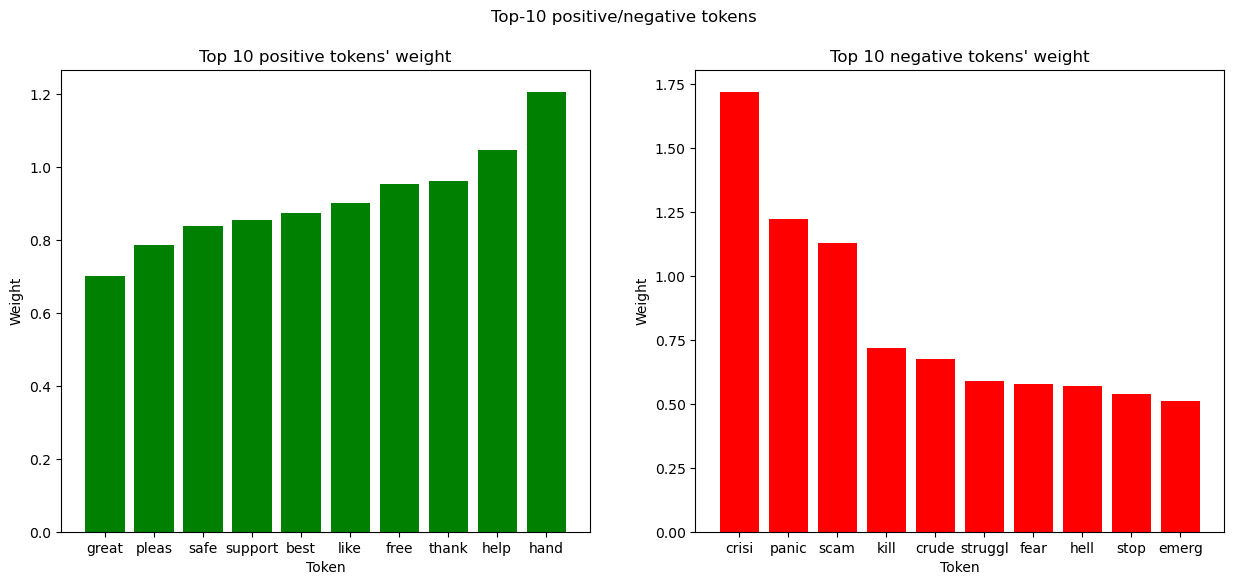

In [1654]:
weights = clf_cv_df.coef_[0]
tokens = np.array(cv_df.get_feature_names_out())

top10_positive_tokens = np.argsort(weights)[-10:]
top10_negative_tokens = np.argsort(weights)[:10]

fig, ax = plt.subplots(1, 2, figsize=(15, 6))
fig.suptitle("Top-10 positive/negative tokens")


pos = plt.subplot(121)
plt.bar(tokens[top10_positive_tokens], weights[top10_positive_tokens], color="green")
pos.set_title("Top 10 positive tokens' weight")
pos.set_xlabel("Token")
pos.set_ylabel("Weight")

neg = plt.subplot(122)
plt.bar(tokens[top10_negative_tokens], np.abs(weights[top10_negative_tokens]), color="red")
neg.set_title("Top 10 negative tokens' weight")
neg.set_xlabel("Token")
neg.set_ylabel("Weight")

plt.show()

**Ответ:** 
* Наиболее влиятельными позитивным токенами являются добрые прилагательные: <i>safe, pleas, best</i>; слова, в том или ином роде означающие поддержку безопасность: <i>support, safe, thank, help, free</i>. Возможно, hand наиболее позитивный токен в связи с идиомой <i>give/lend someone a helping hand</i>.
* Негативными токенами являются слова, описывающие ужасные события в жизни людей: кризис, паника, мошенничество, убийства, страх, катастрофа, болезнь, драка и так далее. Слово <i>stop</i> в топе из-за политических лозунгов: часто его добавляют в начале с целью прекратить что-либо.

## Задание 7 Другие признаки (1.5 балла)

Мы были сконцентрированы на работе с текстами твиттов и не использовали другие признаки - имена пользователя, дату и местоположение

Изучите признаки UserName и ScreenName. полезны ли они? Если полезны, то закодируйте их, добавьте к матрице с отскалированными признаками, обучите логистическую регрессию, замерьте качество.

In [1659]:
from sklearn.preprocessing import OneHotEncoder
from scipy.sparse import hstack

In [1660]:
X = df[['UserName', 'ScreenName', 'OriginalTweet']]
y = df['Sentiment']

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.3, random_state=0)
# В связи с тем, что в тестовой выборке могут оказаться пользователи, не входящие в обучающую выборке, 
# то необходимо handle_unknown="ignore".
enc = OneHotEncoder(handle_unknown="ignore") 
X_train_new = enc.fit_transform(X_train)
X_test_new = enc.transform(X_test)

X_train_new = hstack([bow_tfidf, X_train_new])
X_test_new = hstack([bow_test_tfidf, X_test_new])

model = LogisticRegression(max_iter=200, random_state=0)
model.fit(X_train_new, y_train)
y_pred = model.predict(X_test_new)

print(f"Accuracy based on UserName & ScreenName: {round(accuracy_score(y_test, y_pred), 4)}")

Accuracy based on UserName & ScreenName: 0.8476


**Ответ:** Качество улучшилось всего на одну тысячную относительно погрешности, поэтому я считаю признаки UserName и ScreenName бесполезными.

Изучите признак TweetAt в обучающей выборке: преобразуйте его к типу datetime и нарисуйте его гистограмму с разделением по цвету на основе целевой переменной. Полезен ли он? Если полезен, то закодируйте его, добавьте к матрице с отскалированными признаками, обучите логистическую регрессию, замерьте качество.

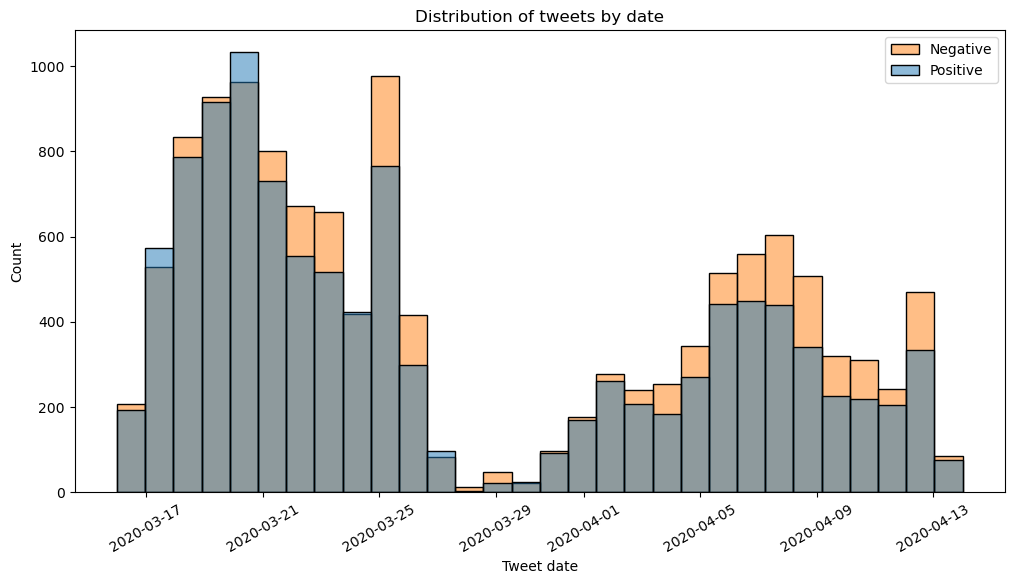

In [1663]:
train['TweetAt'] = pd.to_datetime(train['TweetAt'], format='%d-%m-%Y')
X = train[['TweetAt', 'OriginalTweet']]
y = train['Sentiment']
labels = ['Negative', 'Positive']

plt.figure(figsize=(12, 6))
sns.histplot(data=train, x='TweetAt', hue='Sentiment', bins=30)

plt.title('Distribution of tweets by date')
plt.xlabel('Tweet date')
plt.ylabel('Count')
plt.legend(labels=labels)
plt.xticks(rotation=30)
plt.show()

**Ответ:** В целом, по данным за месяц видим картину, что всегда преобладают негативные твитты. Это довольно очевидно, потому что люди чаще пишут что-то негативное, о чем-то жалуются и прочее. Заметим, <i>2023-03-25</i> негативных твиттов на порядок больше. Полагаю, что именно в эту дату пришлись новости о начале пандемии: все уходили на карантин и самоизоляцию. И далее люди начали регулярно писать больше негативные твитты спустя 1-2 недели изоляции, возможно, из-за того, что им осточертело сидеть дома. Но в целом, не видна существенная разница позитивных и негативных твиттов в зависимости от даты.



Поработайте с признаком Location в обучающей выборке. Сколько уникальных значений?

In [1689]:
X = df['Location']
y = df['Sentiment']

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.3, random_state=0)
print(f"Количество уникальных значений признака Location: {X_train.nunique()}")

Количество уникальных значений признака Location: 7887


Постройте гистограмму топ-10 по популярности местоположений (исключая Unknown)

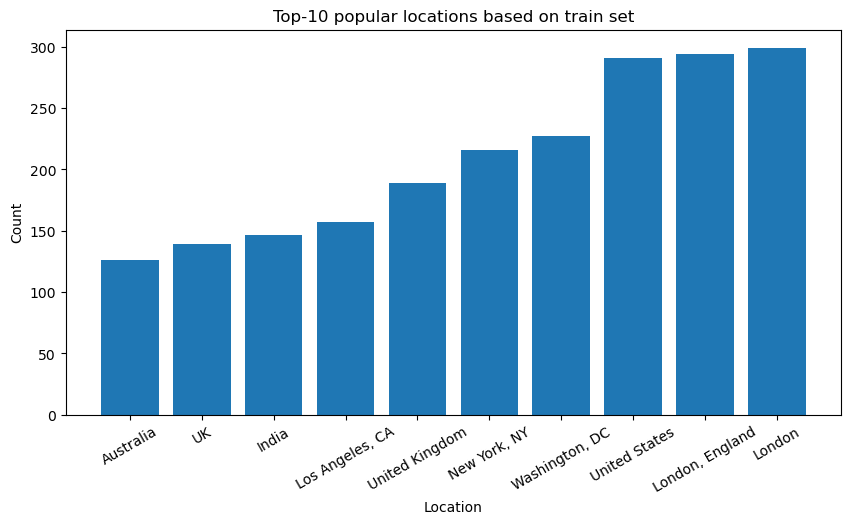

In [1694]:
fig = plt.figure(figsize=(10, 5))
top10_locations = X_train.value_counts()[1:11]

plt.bar(top10_locations.index[::-1], top10_locations.values[::-1])
plt.xlabel("Location")
plt.ylabel("Count")
plt.title("Top-10 popular locations based on train set")
plt.xticks(rotation=30)

plt.show()

Видно, что многие местоположения включают в себя более точное название места, чем другие (Например, у некоторых стоит London, UK; а у некоторых просто UK или United Kingdom).

Создайте новый признак WiderLocation, который содержит самое широкое местоположение (например, из London, UK должно получиться UK). Сколько уникальных категорий теперь? Постройте аналогичную гистограмму.

In [1707]:
X_train['WiderLocation'] = X_train.str.split(',').str[-1].str.strip()

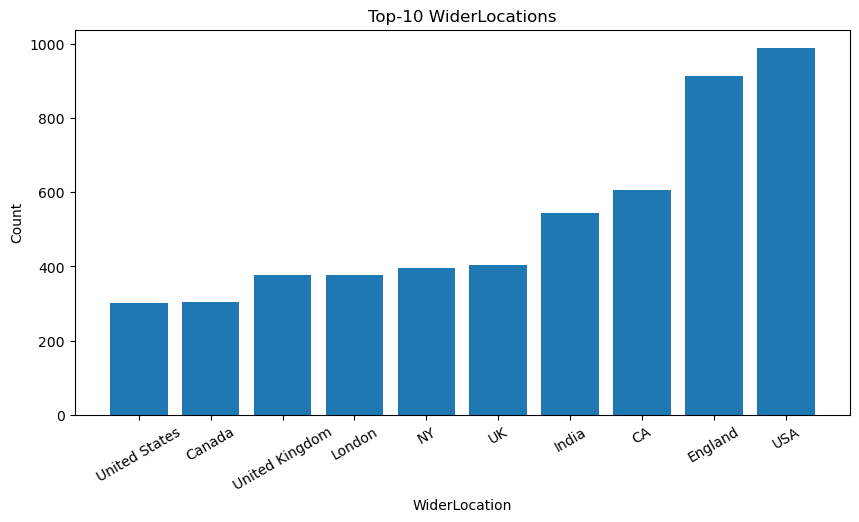

In [1709]:
top_wider_locations = X_train['WiderLocation'].value_counts()[1:11]

plt.figure(figsize=(10, 5))
plt.bar(top_wider_locations.index[::-1], top_wider_locations.values[::-1])

plt.xlabel('WiderLocation')
plt.ylabel('Count')
plt.title('Top-10 WiderLocations')
plt.xticks(rotation=30)
plt.show()

Закодируйте признак WiderLocation с помощью OHE таким образом, чтобы создались только столбцы для местоположений, которые встречаются более одного раза. Сколько таких значений?


In [1712]:
import pandas as pd

location_counts = X_train['WiderLocation'].value_counts()
locations = location_counts[location_counts > 1].index
filtered = pd.get_dummies(X_train['WiderLocation'].where(X_train['WiderLocation'].isin(locations)), prefix='WiderLocation')

print(f"Количество местоположений: {filtered.shape[1]}")

Количество местоположений: 989


Добавьте этот признак к матрице отскалированных текстовых признаков, обучите логистическую регрессию, замерьте качество. Как оно изменилось? Оказался ли признак полезным?


*Подсказка:* используйте параметр `categories` в энкодере.

In [1118]:
# -- YOUR CODE HERE --

**Ответ:** # -- YOUR ANSWER HERE --